In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [2]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

    def get_parameters(self):
        return self.weights, self.biases

    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases


In [3]:
class Layer_Dropout:
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs, training):
        # Save input values
        self.inputs = inputs

        # If not in the training mode - return values
        if not training:
            self.output = inputs.copy()
            return

        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

In [4]:
class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs

In [5]:
class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

    def predictions(self, outputs):
        return outputs

In [6]:
class Activation_Softmax:
    def forward(self, inputs, training):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1,keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)

In [7]:
class Optimizer_RMSprop:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [8]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [9]:
class Loss:
    def regularization_loss(self):
        regularization_loss = 0
        # Calculate regularization loss
        # iterate all trainable layers
        for layer in self.trainable_layers:
            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        # If just data loss - return it
        if not include_regularization:
            return data_loss
        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Calculates accumulated loss
    def calculate_accumulated(self, *, include_regularization=False):
        # Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count
        # If just data loss - return it
        if not include_regularization:
            return data_loss
        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Reset variables for accumulated loss
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


In [10]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true,axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [11]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [12]:
class Loss_BinaryCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +(1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [13]:
class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

In [14]:
class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

In [15]:
class Accuracy:
    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):
        # Get comparison results
        comparisons = self.compare(predictions, y)
        # Calculate an accuracy
        accuracy = np.mean(comparisons)
        # Add accumulated sum of matching values and sample count
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        # Return accuracy
        return accuracy

    # Calculates accumulated accuracy
    def calculate_accumulated(self):
        # Calculate an accuracy
        accuracy = self.accumulated_sum / self.accumulated_count
        # Return the data and regularization losses
        return accuracy

    # Reset variables for accumulated accuracy
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

In [16]:
# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):
    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass
    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y

In [17]:
class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None

    # Calculates precision value
    # based on passed-in ground truth values
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision

In [45]:
class Model:
    def __init__(self):
        self.layers = []
        self.softmax_classifier_output = None
        #used for plotting accuracy graph
        self.accuracy_history = []

    def add(self, layer):
        self.layers.append(layer)

    def set(self, *, loss=None, optimizer=None, accuracy=None):
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy

    def finalize(self):
        # Create and set the input layer
        self.input_layer = Layer_Input()

        # Count all the objects
        layer_count = len(self.layers)

        # Initialize a list containing trainable layers:
        self.trainable_layers = []

        # Iterate the objects
        for i in range(layer_count):

            # If it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]

            # All layers except for the first and the last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]

            # The last layer - the next object is the loss
            # Also let's save aside the reference to the last object
            # whose output is the model's output
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]


            # If layer contains an attribute called "weights",
            # it's a trainable layer -
            # add it to the list of trainable layers
            # We don't need to check for biases -
            # checking for weights is enough
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        # Update loss object with trainable layers
        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)

        # If output activation is Softmax and
        # loss function is Categorical Cross-Entropy
        # create an object of combined activation
        # and loss function containing
        # faster gradient calculation
        if isinstance(self.layers[-1], Activation_Softmax) and \
           isinstance(self.loss, Loss_CategoricalCrossentropy):
            # Create an object of combined activation
            # and loss functions
            self.softmax_classifier_output = \
                Activation_Softmax_Loss_CategoricalCrossentropy()

    # Train the model
    def train(self, X, y, *, epochs=1, batch_size=None,
              print_every=1, validation_data=None):

        # Initialize accuracy object
        self.accuracy.init(y)

        # Default value if batch size is not being set
        train_steps = 1

        # Calculate number of steps
        if batch_size is not None:
            train_steps = len(X) // batch_size
            # Dividing rounds down. If there are some remaining
            # data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if train_steps * batch_size < len(X):
                train_steps += 1

        # Main training loop
        for epoch in range(1, epochs+1):

            # Print epoch number
            print(f'epoch: {epoch}')

            # Reset accumulated values in loss and accuracy objects
            self.loss.new_pass()
            self.accuracy.new_pass()

            # Iterate over steps
            for step in range(train_steps):

                # If batch size is not set -
                # train using one step and full dataset
                if batch_size is None:
                    batch_X = X
                    batch_y = y

                # Otherwise slice a batch
                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]

                # Perform the forward pass
                output = self.forward(batch_X, training=True)

                # Calculate loss
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss

                # Get predictions and calculate an accuracy
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)
                self.accuracy_history.append(accuracy)  # Add accuracy to history


                # Perform backward pass
                self.backward(output, batch_y)

                # Optimize (update parameters)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()


                # Print a summary
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, ' +
                          f'acc: {accuracy:.3f}, ' +
                          f'loss: {loss:.3f} (' +
                          f'data_loss: {data_loss:.3f}, ' +
                          f'reg_loss: {regularization_loss:.3f}), ' +
                          f'lr: {self.optimizer.current_learning_rate}')

            # Get and print epoch loss and accuracy
            epoch_data_loss, epoch_regularization_loss = \
                self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()

            print(f'training, ' +
                  f'acc: {epoch_accuracy:.3f}, ' +
                  f'loss: {epoch_loss:.3f} (' +
                  f'data_loss: {epoch_data_loss:.3f}, ' +
                  f'reg_loss: {epoch_regularization_loss:.3f}), ' +
                  f'lr: {self.optimizer.current_learning_rate}')


            # If there is the validation data
            if validation_data is not None:

                # Evaluate the model:
                self.evaluate(*validation_data, batch_size=batch_size)

        self.plot_accuracy()

    # Evaluates the model using passed-in dataset
    def evaluate(self, X_val, y_val, *, batch_size=None):

        # Default value if batch size is not being set
        validation_steps = 1

        # Calculate number of steps
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            # Dividing rounds down. If there are some remaining
            # data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1

        # Reset accumulated values in loss
        # and accuracy objects
        self.loss.new_pass()
        self.accuracy.new_pass()


        # Iterate over steps
        for step in range(validation_steps):

            # If batch size is not set -
            # train using one step and full dataset
            if batch_size is None:
                batch_X = X_val
                batch_y = y_val

            # Otherwise slice a batch
            else:
                batch_X = X_val[
                    step*batch_size:(step+1)*batch_size
                ]
                batch_y = y_val[
                    step*batch_size:(step+1)*batch_size
                ]

            # Perform the forward pass
            output = self.forward(batch_X, training=False)

            # Calculate the loss
            self.loss.calculate(output, batch_y)

            # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                              output)
            self.accuracy.calculate(predictions, batch_y)

        # Get and print validation loss and accuracy
        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()

        # Print a summary
        print(f'validation, ' +
              f'acc: {validation_accuracy:.3f}, ' +
              f'loss: {validation_loss:.3f}')

    # Predicts on the samples
    def predict(self, X, *, batch_size=None):

        # Default value if batch size is not being set
        prediction_steps = 1

        # Calculate number of steps
        if batch_size is not None:
            prediction_steps = len(X) // batch_size

            # Dividing rounds down. If there are some remaining
            # data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1

        # Model outputs
        output = []

        # Iterate over steps
        for step in range(prediction_steps):

            # If batch size is not set -
            # train using one step and full dataset
            if batch_size is None:
                batch_X = X

            # Otherwise slice a batch
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]

            # Perform the forward pass
            batch_output = self.forward(batch_X, training=False)

            # Append batch prediction to the list of predictions
            output.append(batch_output)

        # Stack and return results
        return np.vstack(output)

    # Performs forward pass
    def forward(self, X, training):

        # Call forward method on the input layer
        # this will set the output property that
        # the first layer in "prev" object is expecting
        self.input_layer.forward(X, training)

        # Call forward method of every object in a chain
        # Pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        # "layer" is now the last object from the list,
        # return its output
        return layer.output

    def backward(self, output, y):
        # If softmax classifier
        if self.softmax_classifier_output is not None:
            # First call backward method
            # on the combined activation/loss
            # this will set dinputs property
            self.softmax_classifier_output.backward(output, y)

            # Since we'll not call backward method of the last layer
            # which is Softmax activation
            # as we used combined activation/loss
            # object, let's set dinputs in this object
            self.layers[-1].dinputs = \
                self.softmax_classifier_output.dinputs

            # Call backward method going through
            # all the objects but last
            # in reversed order passing dinputs as a parameter
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)

            return

        # First call backward method on the loss
        # this will set dinputs property that the last
        # layer will try to access shortly
        self.loss.backward(output, y)

        # Call backward method going through all the objects
        # in reversed order passing dinputs as a parameter
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)

    # Retrieves and returns parameters of trainable layers
    def get_parameters(self):
        # Create a list for parameters
        parameters = []
        # Iterable trainable layers and get their parameters
        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())
        # Return a list
        return parameters


    # Updates the model with new parameters
    def set_parameters(self, parameters):

        # Iterate over the parameters and layers
        # and update each layers with each set of the parameters
        for parameter_set, layer in zip(parameters,
                                        self.trainable_layers):
            layer.set_parameters(*parameter_set)

    # Plot accuracy graph
    def plot_accuracy(self):
        epochs = len(self.accuracy_history)
        plt.plot(range(1, epochs+1), self.accuracy_history)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.show()

In [19]:
def load_dataset(dataset, path):

    # Read the CSV file
    data = pd.read_csv(os.path.join(path, dataset))

    # Extract the pixel values and the labels
    X = data.drop(['0'], axis=1).values
    y = data['0'].values

    # Convert the labels to numerical values
    y = [ord(label)-ord('A') for label in y]

    # Reshape the data to match the image format
    X = X.reshape(-1, 28, 28, 1)

    # Normalize the pixel values
    X = X.astype('float32') / 255.0

    # Return the data as numpy arrays
    return np.array(X), np.array(y)

In [20]:
dataset_path = os.getcwd()
dataset_path += "\\A_Z Handwritten Data.csv"
dataset_path_path = os.path.abspath(dataset_path)

In [21]:
df = pd.read_csv(dataset_path)

class_column = df['0']
del df['0']

X = df
y = class_column

In [22]:
del df

In [23]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.35, random_state=40)

In [24]:
X = (np.array(X).reshape(X.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (np.array(X_test).reshape(X_test.shape[0], -1).astype(np.float32) - 127.5) / 127.5

## TRAINING THE MODEL

epoch: 1
step: 0, acc: 0.031, loss: 3.258 (data_loss: 3.258, reg_loss: 0.000), lr: 0.001


C:\Users\mirza\AppData\Local\Temp\ipykernel_3884\978737833.py:116: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_y = y[step*batch_size:(step+1)*batch_size]


step: 300, acc: 0.680, loss: 1.058 (data_loss: 1.058, reg_loss: 0.000), lr: 0.001
step: 600, acc: 0.859, loss: 0.440 (data_loss: 0.440, reg_loss: 0.000), lr: 0.001
step: 900, acc: 0.914, loss: 0.335 (data_loss: 0.335, reg_loss: 0.000), lr: 0.001
step: 1200, acc: 0.867, loss: 0.384 (data_loss: 0.384, reg_loss: 0.000), lr: 0.001
step: 1500, acc: 0.922, loss: 0.361 (data_loss: 0.361, reg_loss: 0.000), lr: 0.001
step: 1800, acc: 0.922, loss: 0.221 (data_loss: 0.221, reg_loss: 0.000), lr: 0.001
step: 1891, acc: 0.909, loss: 0.287 (data_loss: 0.287, reg_loss: 0.000), lr: 0.001
training, acc: 0.832, loss: 0.580 (data_loss: 0.580, reg_loss: 0.000), lr: 0.001


C:\Users\mirza\AppData\Local\Temp\ipykernel_3884\978737833.py:207: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_y = y_val[


validation, acc: 0.923, loss: 0.272
epoch: 2
step: 0, acc: 0.930, loss: 0.315 (data_loss: 0.315, reg_loss: 0.000), lr: 0.001
step: 300, acc: 0.883, loss: 0.450 (data_loss: 0.450, reg_loss: 0.000), lr: 0.001
step: 600, acc: 0.977, loss: 0.216 (data_loss: 0.216, reg_loss: 0.000), lr: 0.001
step: 900, acc: 0.969, loss: 0.140 (data_loss: 0.140, reg_loss: 0.000), lr: 0.001
step: 1200, acc: 0.953, loss: 0.198 (data_loss: 0.198, reg_loss: 0.000), lr: 0.001
step: 1500, acc: 0.961, loss: 0.213 (data_loss: 0.213, reg_loss: 0.000), lr: 0.001
step: 1800, acc: 0.977, loss: 0.144 (data_loss: 0.144, reg_loss: 0.000), lr: 0.001
step: 1891, acc: 0.932, loss: 0.208 (data_loss: 0.208, reg_loss: 0.000), lr: 0.001
training, acc: 0.940, loss: 0.212 (data_loss: 0.212, reg_loss: 0.000), lr: 0.001
validation, acc: 0.941, loss: 0.205


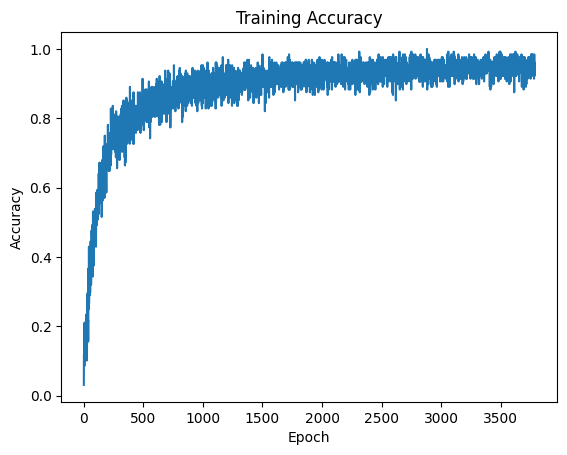

In [56]:
model = Model()

model.add(Layer_Dense(X.shape[1], 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 26))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()

# Train the model
model.train(X, y, validation_data=(X_test, y_test), epochs=2, batch_size=128, print_every=300)


In [57]:
model.evaluate(X_test, y_test)

validation, acc: 0.941, loss: 0.205


In [58]:
y_test_array = np.array(y_test)

In [59]:
confidences = model.predict(X_test[:4])
predictions = model.output_layer_activation.predictions(confidences)
print("Prediction: ", predictions)
print("Actual:     ", y_test_array[:4])

Prediction:  [ 1 12 14  0]
Actual:      [ 1 13 14  0]


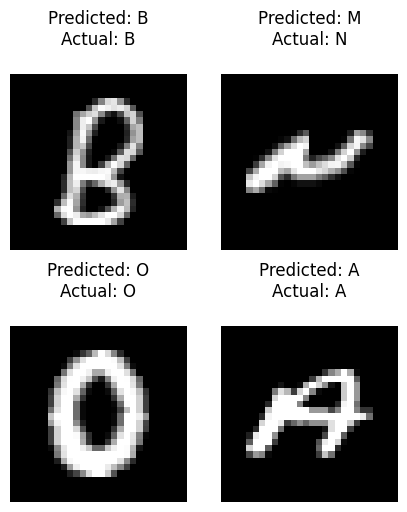

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(5, 6))

# Loop over some random test images and print the predicted letter and confidence rate
for i in range(4):
    # Get the predicted class for the i-th test image
    predicted_class = predictions[i]

    # Get the predicted letter from the class index
    predicted_letter = chr(ord('A') + predicted_class)

    # Get the actual class for the i-th test image
    actual_class = y_test_array[i]

    # Get the actual letter from the class index
    actual_letter = chr(ord('A') + actual_class)

    # Get the subplot coordinates for the i-th image
    row = i // 2
    col = i % 2

    # Display the i-th test image in the appropriate subplot
    axs[row, col].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axs[row, col].set_title(f"Predicted: {predicted_letter}\nActual: {actual_letter}\n")
    axs[row, col].axis('off')

# Show the figure
plt.show()

#### PREVIOUS MODEL WITH DIFFERENT LEARNING RATE

epoch: 1
step: 0, acc: 0.078, loss: 3.258 (data_loss: 3.258, reg_loss: 0.000), lr: 0.2


C:\Users\mirza\AppData\Local\Temp\ipykernel_3884\978737833.py:116: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_y = y[step*batch_size:(step+1)*batch_size]


step: 300, acc: 0.188, loss: 2.947 (data_loss: 2.947, reg_loss: 0.000), lr: 0.2
step: 600, acc: 0.156, loss: 3.025 (data_loss: 3.025, reg_loss: 0.000), lr: 0.2
step: 900, acc: 0.227, loss: 2.827 (data_loss: 2.827, reg_loss: 0.000), lr: 0.2
step: 1200, acc: 0.148, loss: 2.902 (data_loss: 2.902, reg_loss: 0.000), lr: 0.2
step: 1500, acc: 0.109, loss: 3.043 (data_loss: 3.043, reg_loss: 0.000), lr: 0.2
step: 1800, acc: 0.086, loss: 2.999 (data_loss: 2.999, reg_loss: 0.000), lr: 0.2
step: 1891, acc: 0.159, loss: 2.859 (data_loss: 2.859, reg_loss: 0.000), lr: 0.2
training, acc: 0.148, loss: 2.977 (data_loss: 2.977, reg_loss: 0.000), lr: 0.2


C:\Users\mirza\AppData\Local\Temp\ipykernel_3884\978737833.py:207: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_y = y_val[


validation, acc: 0.156, loss: 2.948
epoch: 2
step: 0, acc: 0.078, loss: 3.051 (data_loss: 3.051, reg_loss: 0.000), lr: 0.2
step: 300, acc: 0.188, loss: 2.942 (data_loss: 2.942, reg_loss: 0.000), lr: 0.2
step: 600, acc: 0.156, loss: 3.029 (data_loss: 3.029, reg_loss: 0.000), lr: 0.2
step: 900, acc: 0.227, loss: 2.828 (data_loss: 2.828, reg_loss: 0.000), lr: 0.2
step: 1200, acc: 0.148, loss: 2.902 (data_loss: 2.902, reg_loss: 0.000), lr: 0.2
step: 1500, acc: 0.109, loss: 3.042 (data_loss: 3.042, reg_loss: 0.000), lr: 0.2
step: 1800, acc: 0.086, loss: 2.997 (data_loss: 2.997, reg_loss: 0.000), lr: 0.2
step: 1891, acc: 0.159, loss: 2.859 (data_loss: 2.859, reg_loss: 0.000), lr: 0.2
training, acc: 0.148, loss: 2.948 (data_loss: 2.948, reg_loss: 0.000), lr: 0.2
validation, acc: 0.156, loss: 2.948


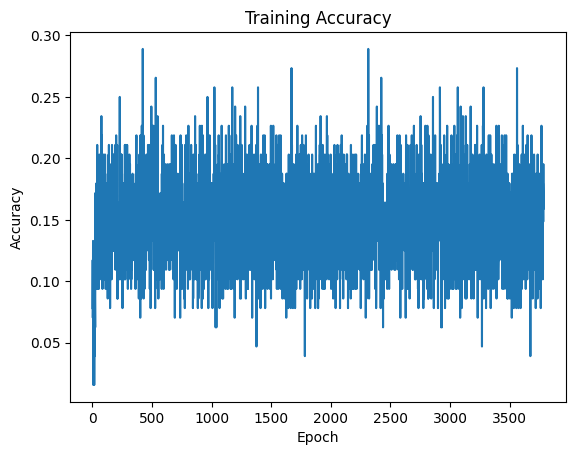

In [62]:
model1 = Model()

model1.add(Layer_Dense(X.shape[1], 128))
model1.add(Activation_ReLU())
model1.add(Layer_Dense(128, 128))
model1.add(Activation_ReLU())
model1.add(Layer_Dense(128, 26))
model1.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model1.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(learning_rate=0.2),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model1.finalize()

# Train the model
model1.train(X, y, validation_data=(X_test, y_test), epochs=2, batch_size=128, print_every=300)

In [63]:
model1.evaluate(X_test, y_test)

validation, acc: 0.156, loss: 2.948


In [64]:
confidences = model1.predict(X_test[:4])
predictions = model1.output_layer_activation.predictions(confidences)
print("Prediction: ", predictions)
print("Actual:     ", y_test_array[:4])

Prediction:  [14 14 14 14]
Actual:      [ 1 13 14  0]


epoch: 1
step: 0, acc: 0.039, loss: 3.258 (data_loss: 3.258, reg_loss: 0.000), lr: 0.001


C:\Users\mirza\AppData\Local\Temp\ipykernel_3884\978737833.py:116: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_y = y[step*batch_size:(step+1)*batch_size]


step: 300, acc: 0.609, loss: 1.190 (data_loss: 1.190, reg_loss: 0.000), lr: 0.001
step: 600, acc: 0.836, loss: 0.586 (data_loss: 0.586, reg_loss: 0.000), lr: 0.001
step: 900, acc: 0.891, loss: 0.469 (data_loss: 0.469, reg_loss: 0.000), lr: 0.001
step: 1200, acc: 0.875, loss: 0.386 (data_loss: 0.386, reg_loss: 0.000), lr: 0.001
step: 1500, acc: 0.898, loss: 0.370 (data_loss: 0.370, reg_loss: 0.000), lr: 0.001
step: 1800, acc: 0.930, loss: 0.229 (data_loss: 0.229, reg_loss: 0.000), lr: 0.001
step: 1891, acc: 0.932, loss: 0.151 (data_loss: 0.151, reg_loss: 0.000), lr: 0.001
training, acc: 0.812, loss: 0.638 (data_loss: 0.638, reg_loss: 0.000), lr: 0.001


C:\Users\mirza\AppData\Local\Temp\ipykernel_3884\978737833.py:207: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_y = y_val[


validation, acc: 0.896, loss: 0.338
epoch: 2
step: 0, acc: 0.930, loss: 0.356 (data_loss: 0.356, reg_loss: 0.000), lr: 0.001
step: 300, acc: 0.891, loss: 0.447 (data_loss: 0.447, reg_loss: 0.000), lr: 0.001
step: 600, acc: 0.953, loss: 0.228 (data_loss: 0.228, reg_loss: 0.000), lr: 0.001
step: 900, acc: 0.969, loss: 0.130 (data_loss: 0.130, reg_loss: 0.000), lr: 0.001
step: 1200, acc: 0.961, loss: 0.156 (data_loss: 0.156, reg_loss: 0.000), lr: 0.001
step: 1500, acc: 0.945, loss: 0.210 (data_loss: 0.210, reg_loss: 0.000), lr: 0.001
step: 1800, acc: 0.953, loss: 0.170 (data_loss: 0.170, reg_loss: 0.000), lr: 0.001
step: 1891, acc: 0.977, loss: 0.157 (data_loss: 0.157, reg_loss: 0.000), lr: 0.001
training, acc: 0.939, loss: 0.213 (data_loss: 0.213, reg_loss: 0.000), lr: 0.001
validation, acc: 0.947, loss: 0.186


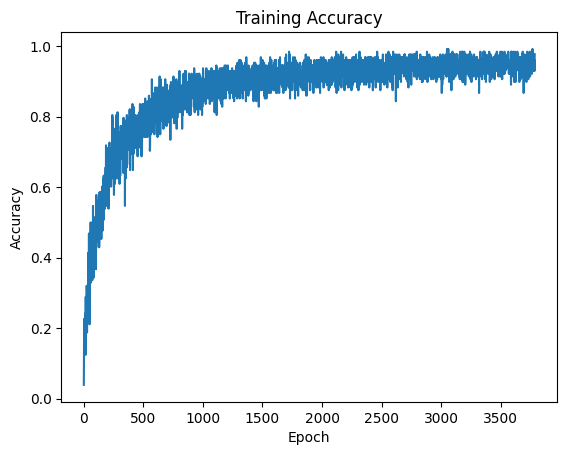

In [51]:
model2 = Model()

model2.add(Layer_Dense(X.shape[1], 128))
model2.add(Activation_ReLU())
model2.add(Layer_Dense(128, 128))
model2.add(Activation_ReLU())
model2.add(Layer_Dense(128, 26))
model2.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model2.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_RMSprop(),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model2.finalize()

# Train the model
model2.train(X, y, validation_data=(X_test, y_test), epochs=2, batch_size=128, print_every=300)

In [52]:
model2.evaluate(X_test, y_test)

validation, acc: 0.947, loss: 0.186


In [53]:
confidences = model2.predict(X_test[:4])
predictions = model2.output_layer_activation.predictions(confidences)
print("Prediction: ", predictions)
print("Actual:     ", y_test_array[:4])

Prediction:  [ 1 12 14  0]
Actual:      [ 1 13 14  0]


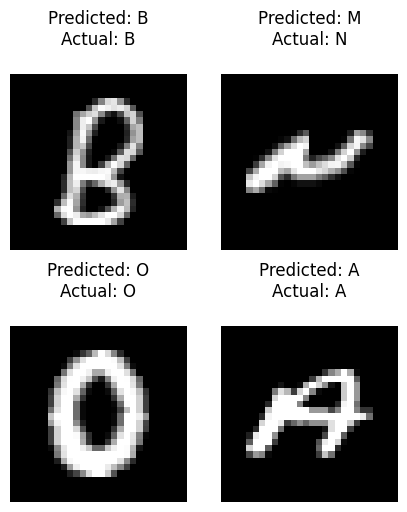

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(5, 6))

for i in range(4):
    predicted_class = predictions[i]

    predicted_letter = chr(ord('A') + predicted_class)

    actual_class = y_test_array[i]

    actual_letter = chr(ord('A') + actual_class)

    row = i // 2
    col = i % 2

    axs[row, col].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axs[row, col].set_title(f"Predicted: {predicted_letter}\nActual: {actual_letter}\n")
    axs[row, col].axis('off')

plt.show()

epoch: 1
step: 0, acc: 0.047, loss: 3.259 (data_loss: 3.259, reg_loss: 0.000), lr: 0.2


C:\Users\mirza\AppData\Local\Temp\ipykernel_3884\978737833.py:116: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_y = y[step*batch_size:(step+1)*batch_size]


step: 300, acc: 0.188, loss: 2.953 (data_loss: 2.953, reg_loss: 0.000), lr: 0.2
step: 600, acc: 0.156, loss: 3.026 (data_loss: 3.026, reg_loss: 0.000), lr: 0.2
step: 900, acc: 0.227, loss: 2.828 (data_loss: 2.828, reg_loss: 0.000), lr: 0.2
step: 1200, acc: 0.148, loss: 2.902 (data_loss: 2.902, reg_loss: 0.000), lr: 0.2
step: 1500, acc: 0.109, loss: 3.042 (data_loss: 3.042, reg_loss: 0.000), lr: 0.2
step: 1800, acc: 0.086, loss: 2.998 (data_loss: 2.998, reg_loss: 0.000), lr: 0.2
step: 1891, acc: 0.159, loss: 2.861 (data_loss: 2.861, reg_loss: 0.000), lr: 0.2
training, acc: 0.149, loss: 2.989 (data_loss: 2.989, reg_loss: 0.000), lr: 0.2


C:\Users\mirza\AppData\Local\Temp\ipykernel_3884\978737833.py:207: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_y = y_val[


validation, acc: 0.156, loss: 2.948
epoch: 2
step: 0, acc: 0.078, loss: 3.047 (data_loss: 3.047, reg_loss: 0.000), lr: 0.2
step: 300, acc: 0.188, loss: 2.943 (data_loss: 2.943, reg_loss: 0.000), lr: 0.2
step: 600, acc: 0.156, loss: 3.029 (data_loss: 3.029, reg_loss: 0.000), lr: 0.2
step: 900, acc: 0.227, loss: 2.828 (data_loss: 2.828, reg_loss: 0.000), lr: 0.2
step: 1200, acc: 0.148, loss: 2.902 (data_loss: 2.902, reg_loss: 0.000), lr: 0.2
step: 1500, acc: 0.109, loss: 3.042 (data_loss: 3.042, reg_loss: 0.000), lr: 0.2
step: 1800, acc: 0.086, loss: 2.997 (data_loss: 2.997, reg_loss: 0.000), lr: 0.2
step: 1891, acc: 0.159, loss: 2.859 (data_loss: 2.859, reg_loss: 0.000), lr: 0.2
training, acc: 0.148, loss: 2.948 (data_loss: 2.948, reg_loss: 0.000), lr: 0.2
validation, acc: 0.156, loss: 2.948


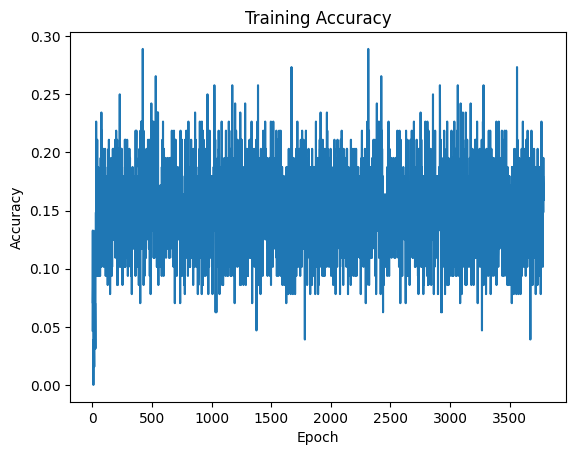

In [65]:
model3 = Model()

model3.add(Layer_Dense(X.shape[1], 128))
model3.add(Activation_ReLU())
model3.add(Layer_Dense(128, 128))
model3.add(Activation_ReLU())
model3.add(Layer_Dense(128, 26))
model3.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model3.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(learning_rate=0.2),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model3.finalize()

# Train the model
model3.train(X, y, validation_data=(X_test, y_test), epochs=2, batch_size=128, print_every=300)

In [66]:
model3.evaluate(X_test, y_test)

validation, acc: 0.156, loss: 2.948


In [67]:
confidences = model3.predict(X_test[:4])
predictions = model3.output_layer_activation.predictions(confidences)
print("Prediction: ", predictions)
print("Actual:     ", y_test_array[:4])

Prediction:  [14 14 14 14]
Actual:      [ 1 13 14  0]
